<a href="https://colab.research.google.com/github/MyDearGreatTeacher/AI4high/blob/master/Keras_imdb_rnn_ErrorCorrection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  錯誤修正範例


網路下載的程式並不一定會順利在Google Colab上執行

學習修正程式碼也是重要的一環

剛好在Google Colab要執行教科書上的程式時發生錯誤

到後來解決了

因此紀錄一下修正的過程作為學習


20190504

程式來源:


https://colab.research.google.com/github/csc-training/intro-to-dl/blob/master/day1/keras-imdb-rnn.ipynb#scrollTo=S4bYuYQpj8OD

# IMDB movie review sentiment classification with RNNs

In this notebook, we'll train a recurrent neural network (RNN) for sentiment classification using Keras (with either Theano or Tensorflow as the compute backend).  Keras version $\ge$ 2 is required. This notebook is largely based on the [Understanding recurrent neural networks](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.2-understanding-recurrent-neural-networks.ipynb) by François Chollet.

First, the needed imports. Keras tells us which backend (Theano, Tensorflow, CNTK) it will be using.

In [0]:
%matplotlib inline

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM, CuDNNLSTM
from keras.datasets import imdb

from distutils.version import LooseVersion as LV
from keras import __version__
from keras import backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print('Using Keras version:', __version__, 'backend:', K.backend())
assert(LV(__version__) >= LV("2.0.0"))

Using TensorFlow backend.


Using Keras version: 2.2.4 backend: tensorflow


## IMDB data set

Next we'll load the IMDB data set. First time we may have to download the data, which can take a while.

The dataset contains 50000 movies reviews from the Internet Movie Database, split into 25000 reviews for training and 25000 reviews for testing. Half of the reviews are positive (1) and half are negative (0).

The dataset has already been preprocessed, and each word has been replaced by an integer index.
The reviews are thus represented as varying-length sequences of integers.
(Word indices begin at "3", as "1" is used to mark the start of a review and "2" represents all out-of-vocabulary words. "0" will be used later to pad shorter reviews to a fixed size.)

In [0]:
# number of most-frequent words to use
nb_words = 10000
# cut texts after this number of words
maxlen = 80

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=nb_words)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print()

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
17465344/17464789 [==============================] - 0s 0us/step


ValueError: ignored

## 解決方法

https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa

解決方法:使用舊版numpy 1.16.1或1.16.2

!pip install numpy==1.16.1

import numpy as np

This version of numpy has the default value of allow_pickle as True

In [0]:
!pip install numpy==1.16.1

     |████████████████████████████████| 17.3MB 2.8MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.16.3
    Uninstalling numpy-1.16.3:
      Successfully uninstalled numpy-1.16.3


In [0]:
import numpy as np

In [0]:
%matplotlib inline

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM, CuDNNLSTM
from keras.datasets import imdb

from distutils.version import LooseVersion as LV
from keras import __version__
from keras import backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print('Using Keras version:', __version__, 'backend:', K.backend())
assert(LV(__version__) >= LV("2.0.0"))

Using TensorFlow backend.


Using Keras version: 2.2.4 backend: tensorflow


In [0]:
# number of most-frequent words to use
nb_words = 10000
# cut texts after this number of words
maxlen = 80

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=nb_words)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print()

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
x_train: (25000,)
x_test: (25000,)

Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


列印出第一筆影評資料

The first movie review in the training set:

In [0]:
print("First review in the training set:\n", x_train[0], "length:", len(x_train[0]), "class:", y_train[0])

First review in the training set:
 [  15  256    4    2    7 3766    5  723   36   71   43  530  476   26
  400  317   46    7    4    2 1029   13  104   88    4  381   15  297
   98   32 2071   56   26  141    6  194 7486   18    4  226   22   21
  134  476   26  480    5  144   30 5535   18   51   36   28  224   92
   25  104    4  226   65   16   38 1334   88   12   16  283    5   16
 4472  113  103   32   15   16 5345   19  178   32] length: 80 class: 1


## Initialization

Let's create an RNN model that has one (or optionally two) LSTM layers. Dropout  The first layer in the network is an *Embedding* layer that converts integer indices to dense vectors of length `embedding_dims`. The output layer contains a single neuron and *sigmoid* non-linearity to match the binary groundtruth (`y_train`). 

Finally, we `compile()` the model, using *binary crossentropy* as the loss function and [*RMSprop*](https://keras.io/optimizers/#rmsprop) as the optimizer.

In [0]:
# model parameters:
embedding_dims = 50
lstm_units = 32

print('Build model...')
model = Sequential()

model.add(Embedding(nb_words,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

model.add(LSTM(lstm_units))
# or if running on a GPU:
#model.add(CuDNNLSTM(lstm_units))

# To stack multiple RNN layers, all RNN layers except the last one need
# to have "return_sequences=True".  An example of using two RNN layers:
#model.add(LSTM(lstm_units, return_sequences=True))
#model.add(LSTM(lstm_units))

model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.summary())

Build model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 50)            500000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 80, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 510,657
Trainable params: 510,657
Non-trainable params: 0
_________________________________________________________________
None


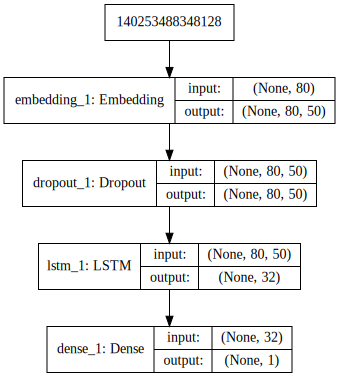

In [0]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Learning

Now we are ready to train our model.  An *epoch* means one pass through the whole training data. Note also that we are using a fraction of the training data as our validation set.

Note that LSTMs are rather slow to train.

In [0]:
%%time
epochs = 5
validation_split = 0.2

history = model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)


Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 16s 782us/step - loss: 0.5158 - acc: 0.7449 - val_loss: 0.4521 - val_acc: 0.7898
Epoch 2/5
20000/20000 [==============================] - 14s 721us/step - loss: 0.3294 - acc: 0.8621 - val_loss: 0.3521 - val_acc: 0.8420
Epoch 3/5
20000/20000 [==============================] - 14s 717us/step - loss: 0.2766 - acc: 0.8885 - val_loss: 0.3765 - val_acc: 0.8308
Epoch 4/5
20000/20000 [==============================] - 14s 707us/step - loss: 0.2500 - acc: 0.8996 - val_loss: 0.3558 - val_acc: 0.8424
Epoch 5/5
20000/20000 [==============================] - 14s 708us/step - loss: 0.2298 - acc: 0.9095 - val_loss: 0.3885 - val_acc: 0.8438
CPU times: user 2min 4s, sys: 5.81 s, total: 2min 9s
Wall time: 1min 13s


Let's plot the data to see how the training progressed. A big gap between training and validation accuracies would suggest overfitting.

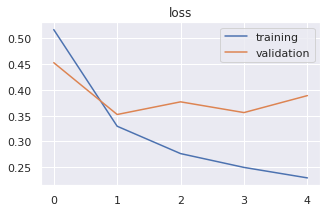

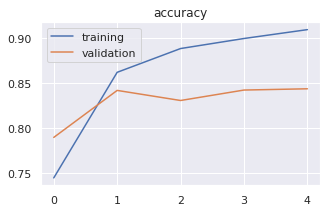

In [0]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'], label='training')
plt.plot(history.epoch,history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'], label='training')
plt.plot(history.epoch,history.history['val_acc'], label='validation')
plt.title('accuracy')
plt.legend(loc='best');

## Inference

For a better measure of the quality of the model, let's see the model accuracy for the test data. 

In [0]:
scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 83.68%


---
*Run this notebook in Google Colaboratory using [this link](https://colab.research.google.com/github/csc-training/intro-to-dl/blob/master/day1/keras-imdb-rnn.ipynb).*